# 13.4 Hardware

Building systems with great performance requires a good understanding of the algorithms and models to capture the statistical aspects of the problem. At the same time it is also indispensable to have at least a modicum of knowledge of the underlying hardware. The current section is no substitute for a proper course on hardware and system design. Instead, it might serve as a starting point for understanding why some algorithms are more efficient than others and how to achieve good throughput.

A good design can easily make a difference of an order of magnitude and, in turn, this can make the difference between being able to train a network and not at all.

We will start by looking at computers. Then we will zoom in to look more carefully at CPUs and GPUs. Lastly, we zoom out to review how multiple computers are connected in a server center or in the cloud.

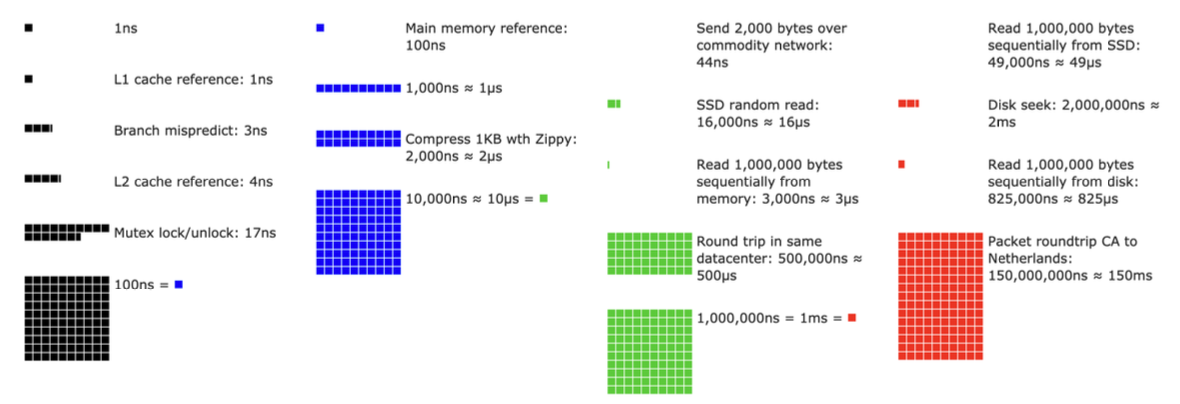


## 13.4.1 Computers

Most deep learning researches and practicioners have access to a computer with a fair amount of memory, computation, some form of an accelerator such as a GPU, or multiple thereof. A computer consists of the following key components:

 -  A processor (also preferred to as a CPU) that is able to execute the programs we give it (in addition to running an operating system and many other things), typically consisting of 8 or more cores.

 - Memory (RAM) to store and retrieve the results from computation, such as weight vectors and activations, and training data.

 - An Ethernet network connection (sometimes multiple) with speeds ranging  from 1 GB/s to 100 GB/s. On high end servers more advanced interconnects can be found.

 - A high speed expansion bus (PCIe) to cnnect the system to one or more GPUs. Servers have up to 8 accelerators, often connected in an advanced topology, while desktop systems have 1 or 2, depending on the budget of the user and the size of the power supply.

 - Durable storage, such as a magnetic hard disk drive, a solid state drive, in many cases connected using the PCIe bus. It provides efficient transfer of training data to the system and storage of intermediate checkpoints as needed.


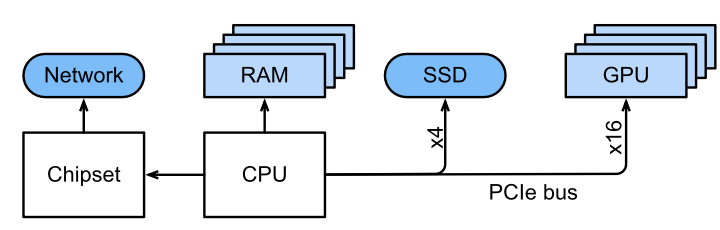

When we run code on a computer we need to shuffle data to the processors (CPUs or GPUs), perform computation, and then move the results off the processor back to RAM and durable storage. Hence, in order to get good performance we need to make sure that this works seamlessly without any one of the systems becoming a major bottleneck. For instance, if we cannot load images quickly enough the processor will not have any work to do.

Likewise, if we cannot move matrices quickly enough to the CPU (or GPU), its processing elements will starve. Finlly, if we want to synchronize multiple computer across the network, the latter should not slow down computation. One option is to interleave communication and computation. Let's have a look at the various components in more detail.


## 13.4.2 Memory

At its most basic memory is used to store data that needs to be readily accessible. At present CPU RAM is typically of the DDR4 variety, offering 20-25GB/s bandwith per module. Each module has a 64-bit wide bus. Typically pairs of memory modules are used to allow for multiple channels. CPUs have between 2 and 4 memory channels, i.e., they have between 40GB/s and 100GB/s peak memory bandwidth. Often there are two banks per channel.

While these numbers are impressive, indeed, they only tell part of the story. When we want to read a portion from memory we first need to tell the memory module where the information can be found. That is, we first need to send the address to RAM. Once this is accomplished we can choose to read just a single 64 bit record or a long sequence of records. The latter is called burst read. In a nutshell, sending an address to memory and setting up the transfer takes approximately 100 ns (details depend on the specific timing coefficients of the memory chips used), every subsequent transfer takes only 0.2 ns. In short, the first read is 500 times as expensive as subsequent ones! Note that we could perform up to 10,000,000 random reads per second. This suggests that we avoid random memory access as far as possible and use burst reads (and writes) instead.

## 13.4.3 Storage

We saw that some of the key characteristics of RAM are bandwidth and latency. The same is true for storage devices, just that the differences can be even more extreme.

### Hard Disk Drives

Hard disk drives (HDDs) have been in use for over half a century. In a nutshell they contain a number of spinning platters with heads that can be positioned to read or write at any given track. High-end disks hold up to 16 TB on 9 platters. One of the key benefits of HDDs is that they are relatively inexpensive. One of their many downsides are their typically catastrophic failure modes and their relatively high read latency.

To understand the latter, consider the fact that HDDs spin at around 7,200 RPM (revolutions per minute). If they were much faster they would shatter due to the centrifugal force exerted on the platters. This has a major downside when it comes to accessing a specific sector on the disk: we need to wait until the platter has rotated in position (we can move the heads but not accelerate the actual disks). Hence it can take over 8 ms until the requested data is available. A common way this is expressed is to say that HDDs can operate at approximately 100 IOPs (input/output operations per second). This number has essentially remained unchanged for the past two decades. Worse still, it is equally difficult to increase bandwidth (it is in the order of 100–200 MB/s). After all, each head reads a track of bits, hence the bit rate only scales with the square root of the information density. As a result, HDDs are quickly becoming relegated to archival storage and low-grade storage for very large datasets.

### Solid Satate Drives

Solid state drives (SSDs) use flash memory to store information persistently. This allows for much faster access to stored records. Modern SSDs can operate at 100,000 to 500,000 IOPs, i.e., up to 3 orders of magnitude faster than HDDs. Furthermore, their bandwidth can reach 1–3GB/s, i.e., one order of magnitude faster than HDDs. These improvements sound almost too good to be true. Indeed, they come with the following caveats, due to the way SSDs are designed.


 - SSDs store information inblocks(256KBorlarger) They can only be written as a whole, which takes significant time. Consequently bit-wise random writes on SSD have very poor performance. Likewise, writing data in general takes significant time since the block has to be read, erased and then rewritten with new information. By now SSD controllers and firmware have developed algorithms to mitigate this. Nonetheless, writes can be much slower, in particular for QLC (quad level cell) SSDs. The key for improved performance is to maintain a queue of operations, to prefer reads and to write in large blocks if possible.

 - The memory cells in SSDs wear out relatively quickly (often already after a few thou- sand writes). Wear-level protection algorithms are able to spread the degradation over many cells. That said, it is not recommended to use SSDs for swapping files or for large aggregations of log-files.

 - Lastly, the massive increase in bandwidth has forced computer designers to attach SSDs directly to the PCIe bus. The drives capable of handling this, referred to as NVMe (Non Volatile Memory enhanced), can use up to 4 PCIe lanes. This amounts to up to 8GB/s on PCIe 4.0.


 ## 13.4.4 CPUs

 Central processing units (CPUs) are the centerpiece of any computer. They consist of a number of key component: 
  - processor cores that are able to execute machine code
  - a bus connecting them (the specific topology differs significantly)
  - caches to allow for higher bandwidth and lower latency memory access than what is possible by reads from main memory.
  - (modern CPUs) vector processing units to aid with high performance linear algebra and convolutoins, as they are common in media processing and machine learning.

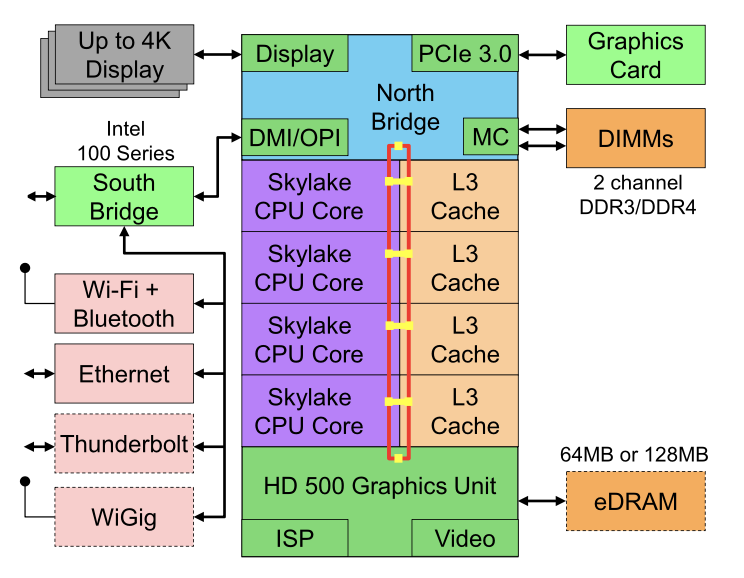

The figure depicts an Intel Skylake consumer-grade quad-core CPU. It has an integrated GPU, caches, and a ringbus connecting the four cores. Peripherals, such as Ethernet, WiFi, Bluetooth, SSD controller, and USB, are either part of the chipset or directly attached (PCIe) to the CPU.

### Microarchitecture

Each of the processor cores consists of a rather sophisticated set of components. While details differ between generations and vencdors, the basic functionality is pretty much standard. The front-end loads instructions and tries to predict which path will be taken (e.g., for control flow). Instructions are then decoded from assembly code to microinstructions. Assembly code is often not the lowest level code that a processor executes. Instead, complex instructions may be decoded into a set of more lower level operations. These are then processed by the actual execution core. Often the latter is capable of performing many operations simultaneously. For instance, the ARM Cortex A77 core of the following figure is able to perform up to 8 operations simultaneously.

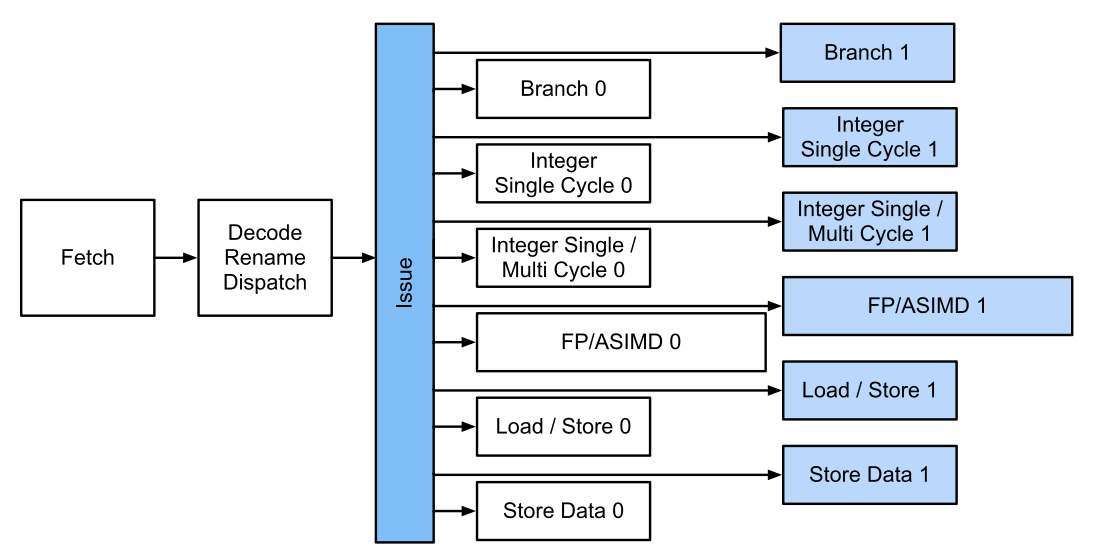

This means that efficient programs might be able to perform more than one instruction per clock cycle, provided that they can be carried out independently. Not all units are created equal. Some specialize in integer instructions whereas others are optimized for floating point performance. To increase throughput, the processor might also follow multiple code paths simultaneously in a branching instruction and then discard the results of the branches not taken. This is why branch prediction units matter (on the front-end) such that only the most promising paths are pursued.


### Vectorization

Deep learning is extremely compute-hungry. Hence, to make CPUs suitable for machine learning, one needs to perform many operations in one clock cycle. This is achieved via vector units. They have different names: 
 - ARM: NEON
 - X86: AVX2 units

A common aspect is that they are able to perform SIMD (single instruction multiple data) operations. The following figure shows how 8 short integers can be added in one clock cycle on ARM.

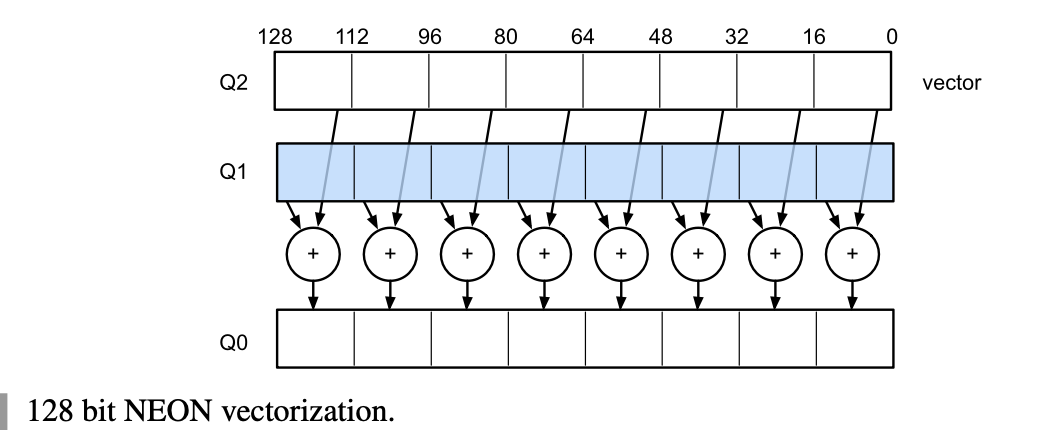


### Cache

Consider the following situation: we have a modest CPU core with 4 cores as depicted above, running at 2 GHz frequency. Moreover, let's assume that we have a IPC (instructions per clock) count of 1 and that units have AVX2 with 256-bit width enabled. Let's furthermore assume that at least one of the registers used for AVX2 operations needs to be retrieved from memory. This means that ths CPU consumes $4 \times 256 bit = 128 bytes$ of data per clock cycle. Unless we are able to transfer $2 \times 10^9 \times 128 = 256 \times 10^9$ bytes to the processor per second the processing elements are going to starve. Unfortunately the memory interface of such a chip only supports $20 - 40 GB/s$ data transfer. The fix is to avoid loading new data from memory as far as possible and rather to cache it locally on the CPU. Commonly following names or concepts are used:

 - Registers: Strictly speaking, it is not a part of the cache. They help stage instructions. That sai, CPU regisers are memory locations that a CPU can access at clock speed without any delay penalty. CPUs have tens of registers. It is up to the compiler (or programmer) to use registers efficiently. For instance the C programming language has a register keyword.
 - L1 caches: First line of defense against high memory bandwidth requirements. L1 caches are tiny (32-64 KB) and often split into data and instruction caches. When data is found in the L1 cache, access is very fast. If they cannot be found there, the search progresses down the cache hierarchy.
 - L2 caches: Depending on architecture design and processor size they might be exclusive. They might be accessible only by a given core or shared among multiple cores. L2 caches are larger (256-512 KB) and slower than L1.
 - L3 caches: Shared among multiple cores and can be quite large. AMD's Epyc 3 server CPUs have a whopping 256 MB of cache spread across multiple chiplets. More typical numbers are in the 4-8 MB range.

 ## 13.4.5 GPUs and other Accelerators

 It is not an exaggeration to claim that deep learning would not have been successful without GPUs. By the same token, it is quite reasonable to argue that GPU manufacturers’ fortunes have increased significantly due to deep learning. This co-evolution of hardware and algo- rithms has led to a situation where for better or worse deep learning is the preferable statistical modeling paradigm. Hence it pays to understand the specific benefits that GPUs and related accelerators such as the TPU (Jouppi et al., 2017).

 Of note is a distinction that is often made in practice: accelerators are optimized either for training or inference. For the latter we only need to compute the forward propagation in a network. No storage of intermediate data is needed for backpropagation. Moreover, we may not need very precise computation (FP16 or INT8 typically suffice). On the other hand, during training all intermediate results need storage to compute gradients. Moreover, ac- cumulating gradients requires higher precision to avoid numerical underflow (or overflow). This means that FP16 (or mixed precision with FP32) is the minimum requirement. All of this necessitates faster and larger memory (HBM2 vs. GDDR6) and more processing power. For instance, NVIDIA’s Turing197 T4 GPUs are optimized for inference whereas the V100 GPUs are preferable for training.

 Recall vectorization as illustrated in Fig. 13.4.5. Adding vector units to a processor core allowed us to increase throughput significantly. For example, in the example in Fig. 13.4.5 we were able to perform 16 operations simultaneously. First, what if we added operations that optimized not just operations between vectors but also between matrices? This strategy led to tensor cores (to be covered shortly). Second, what if we added many more cores? In a nutshell, these two strategies summarize the design decisions in GPUs. Fig. 13.4.7 gives an overview of a basic processing block. It contains 16 integer and 16 floating point units. In addition to that, two tensor cores accelerate a narrow subset of additional operations relevant for deep learning. Each streaming multiprocessor consists of four such blocks.

 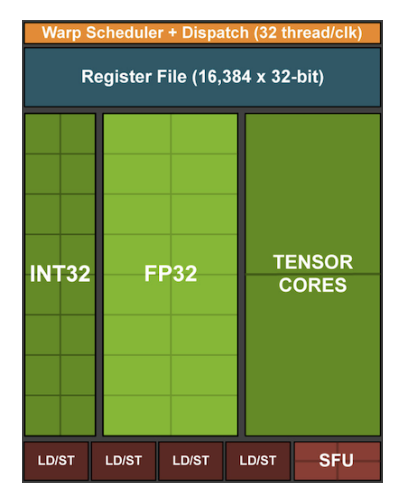

 Next, 12 streaming multiprocessors are grouped into graphics processing clusters which make up the high-end TU102 processors. Ample memory channels and an L2 cache complement the setup. Fig. 13.4.8 has the relevant details. One of the reasons for designing such a device is that individual blocks can be added or removed as needed to allow for more compact chips and to deal with yield issues (faulty modules might not be activated). Fortunately programming such devices is well hidden from the casual deep learning researcher beneath layers of CUDA and framework code. In particular, more than one of the programs might well be executed simultaneously on the GPU, provided that there are available resources. Nonetheless it pays to be aware of the limitations of the devices to avoid picking models that do not fit into device memory.

A last aspect that is worth mentioning in more detail are tensor cores. They are an example of a recent trend of adding more optimized circuits that are specifically effective for deep learning. For instance, the TPU added a systolic array (Kung, 1988) for fast matrix multiplication. There the design was to support a very small number (one for the first generation of TPUs) of large operations. Tensor cores are at the other end. They are optimized for small operations involving between 4 × 4 and 16 × 16 matrices, depending on their numerical precision. Fig. 13.4.9 gives an overview of the optimizations.

## 13.4.6 Networks and Buses

Whenever a single device is insufficient for optimization we need to transfer data to and from it to synchronize processing. This is where networks and buses come in handy. We have a number of design parameters: bandwidth, cost, distance, and flexibility. On one end we have WiFi that has a pretty good range, is very easy to use (no wires, after all), cheap but it offers comparatively medicore bandwidth and latency. No machine learning researcher within their right mind would uwe it to build a cluster of servers. In what follows we focus on interconnects that are suitable for deep learning.

 - PCIe: is a dedicated bus for very high bandwidth point-to-point connections (up to 32 GB/s on PCIe 4.0 in a 16-lane slot) per lane. Latency is in the order of single-digit microseconds (5 us). PCIe links are precious. Processors only have a limited number of them.

 - Ethernet: most commonly used way of connecting computers. While it is significantly slower than PCIe, it is very cheap and resilient to install and covers much longer distances.

 - Switches: allow us to connect multiple devices in a manner where any pair of them can carry out a point-to-point connection simultaneously. For instance, Ethernet switches might connect 40 servers at high cross-sectional bandwidth. Note that switches are not unique to traditional computer networks. Even PCIe lanes can be switched.

 - NVLink: alternative to PCIe when it comes to very high bandwidth interconnects. It offers up to 300 Gbits/s data transfer rate per link.


## 13.4.7 More Latency Numbers

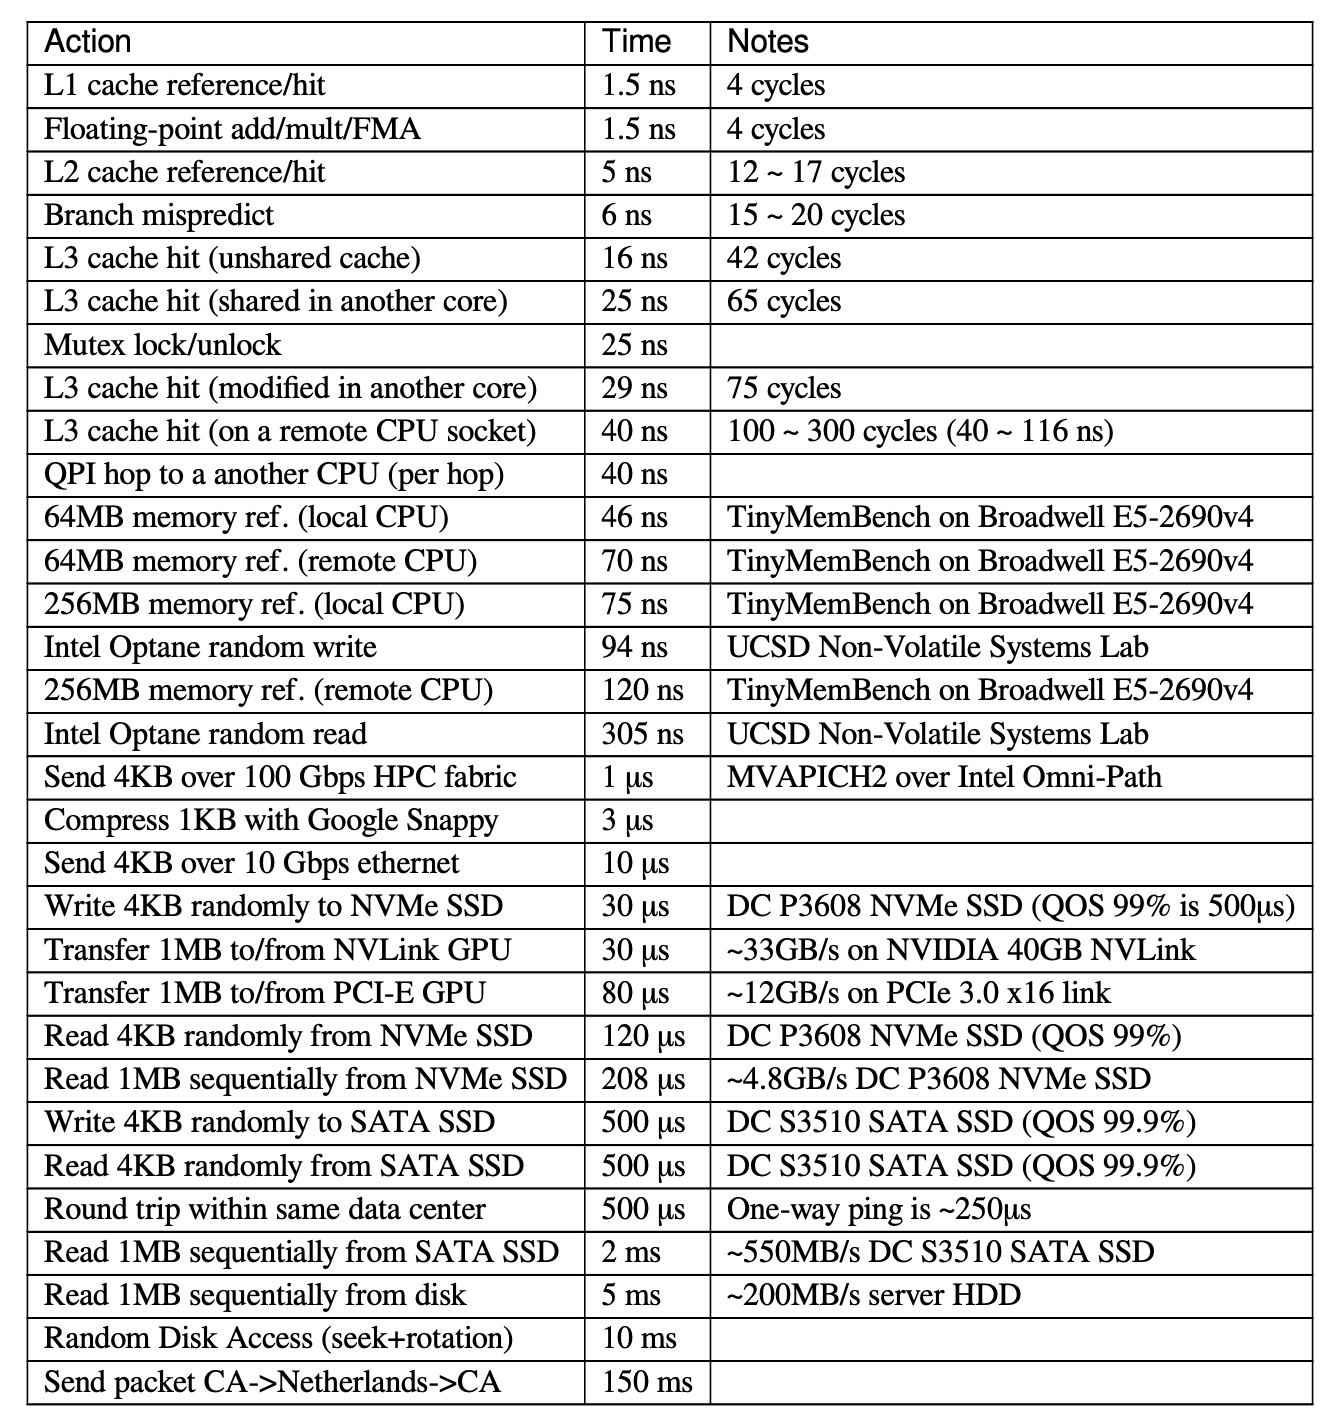